In [1]:
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation

In [2]:
train = DataSet('/home/harllan/nilmtk/data/LAB/lab.h5')
test = DataSet('/home/harllan/nilmtk/data/LAB/lab.h5')
#A casa utilizada do banco LAB
building = 1

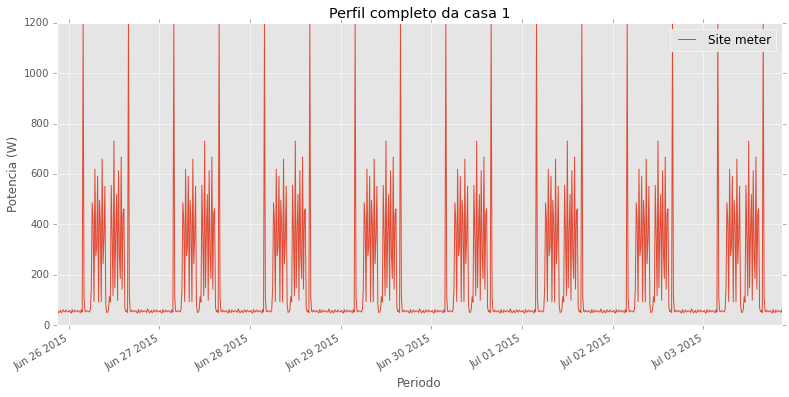

In [3]:
#Gráfico completo da casa
train.buildings[building].elec.mains().plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Perfil completo da casa " + str(building));

In [4]:
#Divide a base: uma parte para treinamento e a outra para teste (desagregação)
#Treinamento termina em 
train.set_window(end="30-6-2015")
#Teste inicia em 
test.set_window(start="30-6-2015")

train_elec = train.buildings[building].elec
test_elec = test.buildings[building].elec

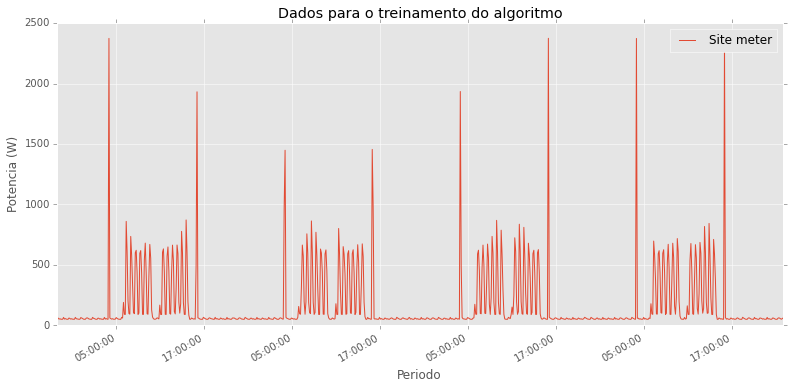

In [5]:
#Gráfico da base de treinamento
train_elec.mains().plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados para o treinamento do algoritmo");

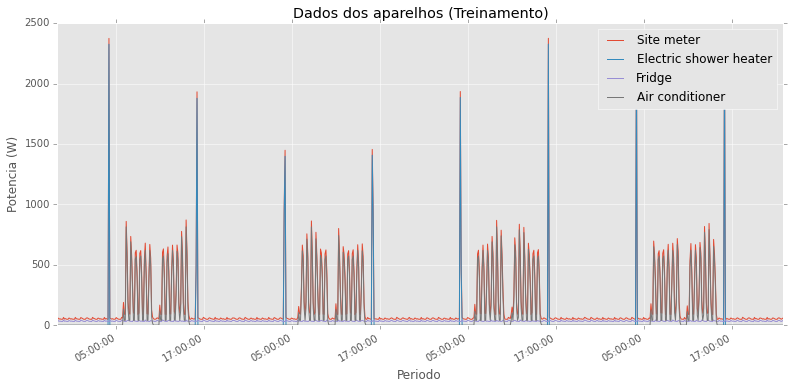

In [6]:
train_elec.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados dos aparelhos (Treinamento)");

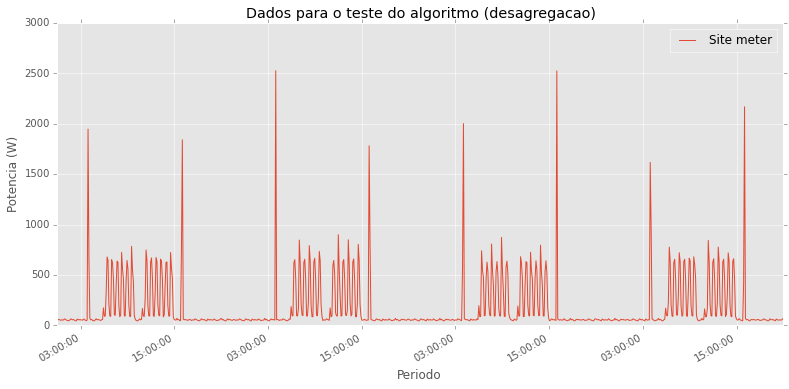

In [7]:
#Gráfico da base de teste (que pretende desagregar)
test_elec.mains().plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados para o teste do algoritmo (desagregacao)");

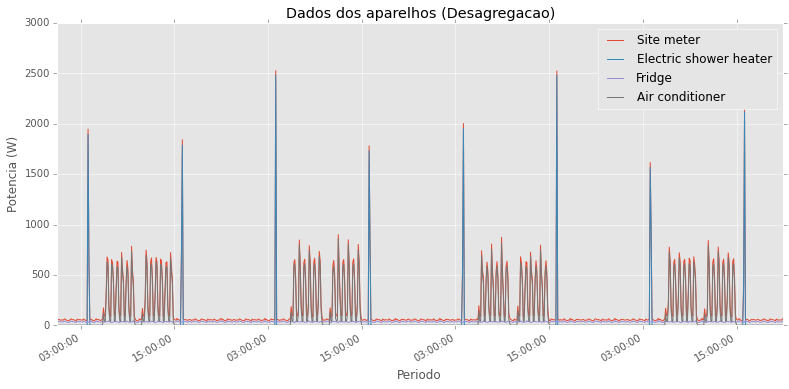

In [8]:
test_elec.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados dos aparelhos (Desagregacao)");

In [9]:
#Selecionando top-3 aparelhos em termos de consumo de energia, que serão usados para treinar os algoritmos
top_3_train_elec = train_elec.submeters().select_top_k(k=3)

3/3 ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])

In [10]:
top_3_train_elec

MeterGroup(meters=
  ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])
)

In [11]:
#FHMM
from nilmtk.disaggregate import fhmm_exact
#Arquivo onde vai ficar os dados da desagregação
disag_filename = '/home/harllan/nilmtk/data/LAB/lab-disag-fhmm-16seg.h5'
#Arquivo com os resultados do tempo
path = '/home/harllan/Documentos/NILMTK_Disag/LAB_Tests/time_algorithms.txt'
#range(x): x é o número de repetições
for i in range(30):
    print('Execution ' + str(i+1))
    result = ''
    #Treinando o algoritmo FHMM com uma frequência de 16 segundos
    start=time.time()
    fhmm = fhmm_exact.FHMM()
    fhmm.train(top_3_train_elec, sample_period=16)
    end=time.time()
    #Tempo de treinamento do algoritmo
    result = str(end-start)
    
    #Desagregando os dados, também para uma frequência de 16 segundos
    start=time.time()
    #Coloca em HDF
    output = HDFDataStore(disag_filename, 'w')
    fhmm.disaggregate(test_elec.mains(), output, sample_period=16)
    output.close()
    end=time.time()
    #Tempo de desagregação
    result = result + ',' + str(end-start) + ',FHMM,16'
    
    #Escrevendo em arquivo.txt
    #'a' é de append, adiciona sem apagar o que já tem no arquivo
    arquivo = open(path, 'a')
    arquivo.write('\n')
    arquivo.write(result)
    arquivo.close()

Execution 1
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])'
Execution 2
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])'
Execution 3
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1

In [12]:
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[building].elec

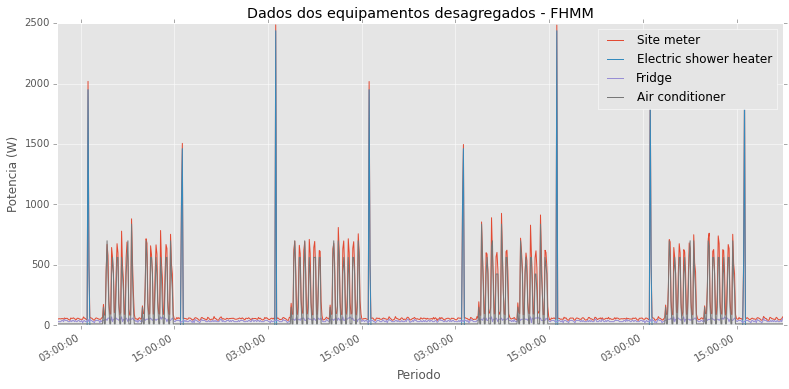

In [13]:
#Equipamentos desagregados
disag_fhmm_elec.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados dos equipamentos desagregados - FHMM");

In [14]:
fridge_disag = disag_fhmm_elec['fridge']
fridge_test = test_elec['fridge']

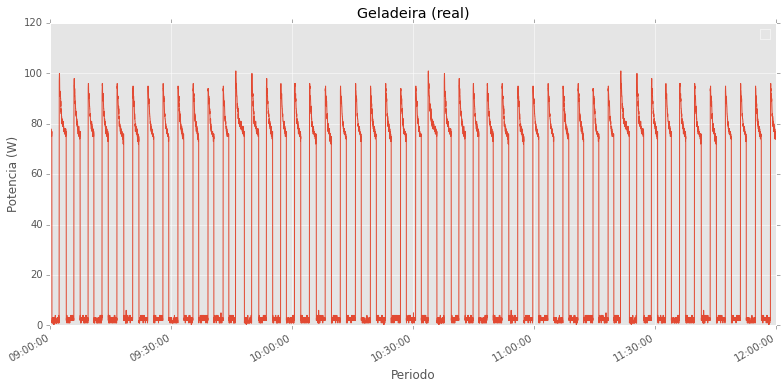

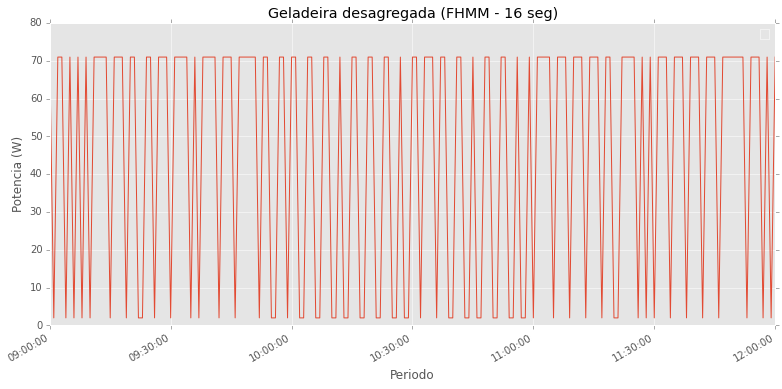

In [15]:
#Geladeira antes da desagregação (dados reais)
fridge_test_df = fridge_test.load().next()
fridge_test_df["2015-07-01 09:00:00":"2015-07-01 12:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira (real)");
plt.legend('');

#Geladeira após desagregação
fridge_disag_df = fridge_disag.load().next()
fridge_disag_df["2015-07-01 09:00:00":"2015-07-01 12:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira desagregada (FHMM - 16 seg)");
plt.legend('');

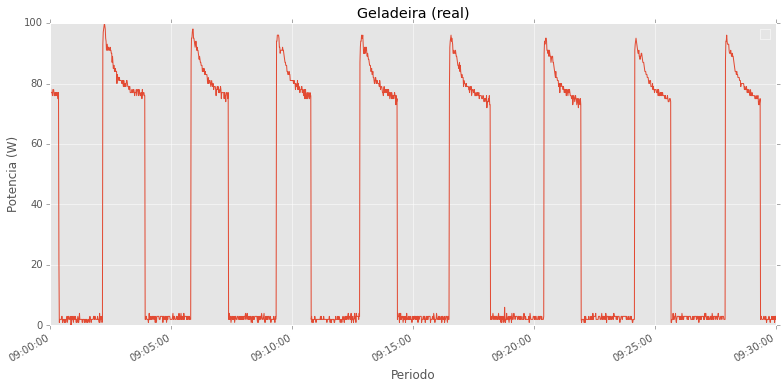

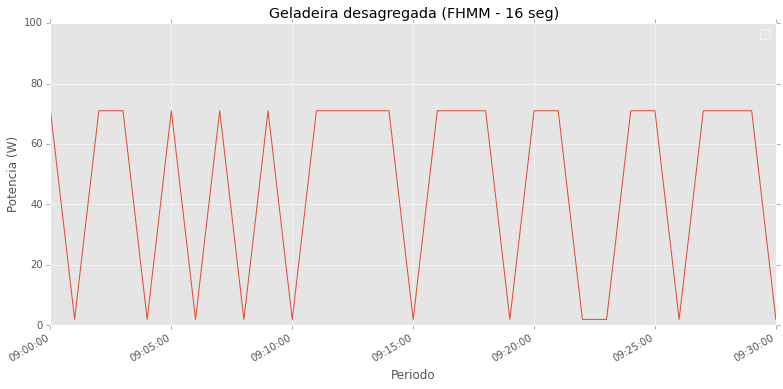

In [16]:
#Geladeira antes da desagregação (dados reais)
fridge_test_df = fridge_test.load().next()
fridge_test_df["2015-07-01 09:00:00":"2015-07-01 09:30:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira (real)");
plt.legend('');

#Geladeira após desagregação
fridge_disag_df = fridge_disag.load().next()
fridge_disag_df["2015-07-01 09:00:00":"2015-07-01 09:30:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.ylim(0,100)
plt.title("Geladeira desagregada (FHMM - 16 seg)");
plt.legend('');

In [17]:
shower_test = test_elec['electric shower heater']
shower_disag = disag_fhmm_elec['electric shower heater']

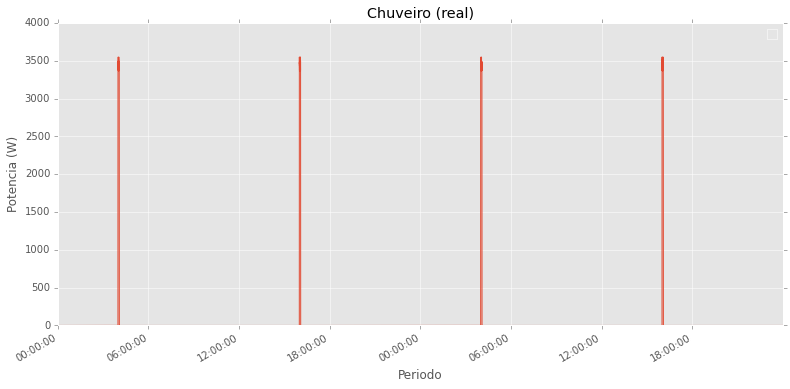

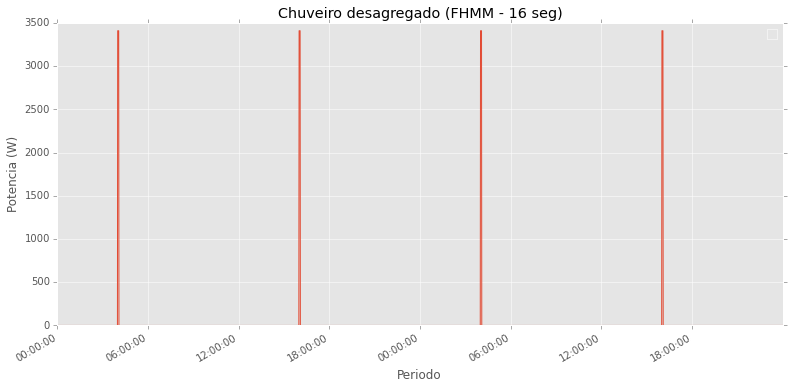

In [18]:
#Chuveiro antes da desagregação (dados reais)
shower_test_df = shower_test.load().next()
shower_test_df["2015-07-01":"2015-07-02"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Chuveiro (real)");
plt.legend('');

#Chuveiro após desagregação
shower_disag_df = shower_disag.load().next()
shower_disag_df["2015-07-01":"2015-07-02"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Chuveiro desagregado (FHMM - 16 seg)");
plt.legend('');

In [19]:
#Ar-condicionado
air_test = test_elec['air conditioner']
air_disag = disag_fhmm_elec['air conditioner']

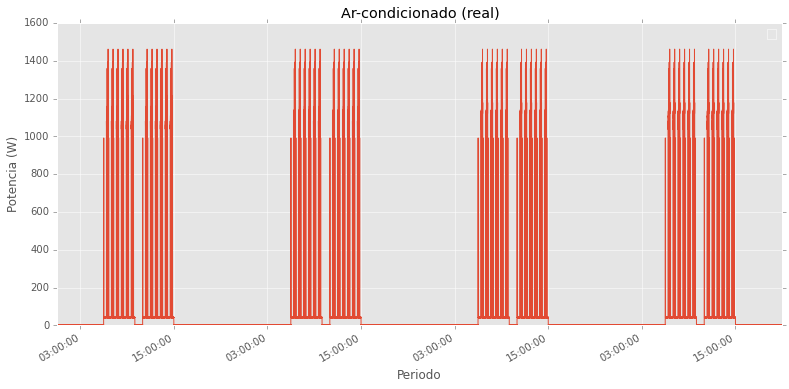

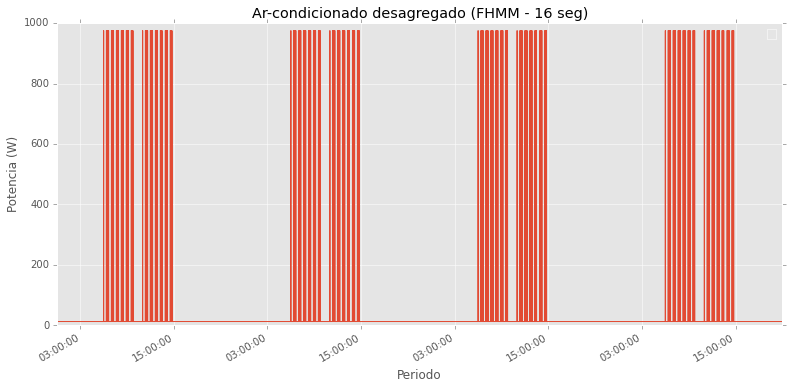

In [20]:
#Ar-condicionado antes da desagregação (dados reais)
air_test_df = air_test.load().next()
air_test_df.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado (real)");
plt.legend('');

#Ar-condicionado após desagregação
air_disag_df = air_disag.load().next()
air_disag_df.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado desagregado (FHMM - 16 seg)");
plt.legend('');

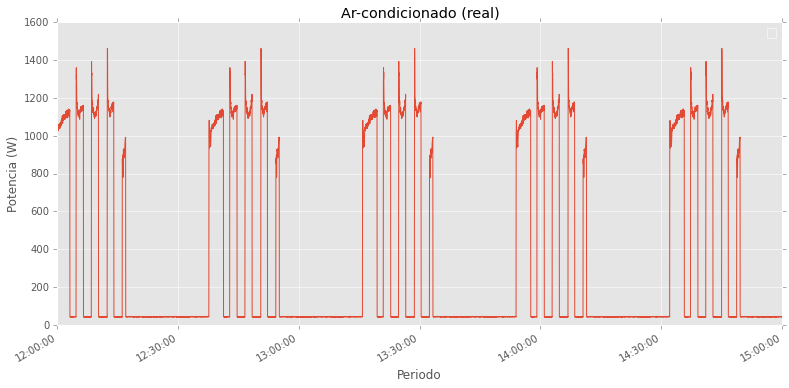

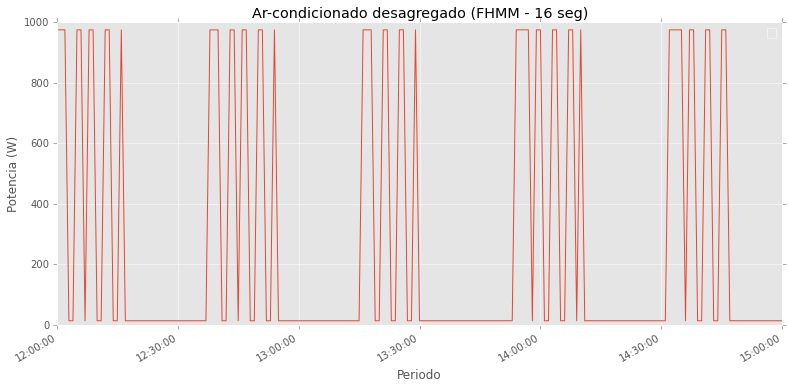

In [21]:
#Ar-condicionado antes da desagregação (dados reais)
air_test_df = air_test.load().next()
air_test_df["2015-07-01 12:00:00":"2015-07-01 15:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado (real)");
plt.legend('');

#Ar-condicionado após desagregação
air_disag_df = air_disag.load().next()
air_disag_df["2015-07-01 12:00:00":"2015-07-01 15:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado desagregado (FHMM - 16 seg)");
plt.legend('');

In [22]:
#Métrica f-score, onde é retornado uma pontuação entre 0 e 1. Valor próximo à 1, significa uma boa acurácia do algoritmo.
from nilmtk.metrics import f1_score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)

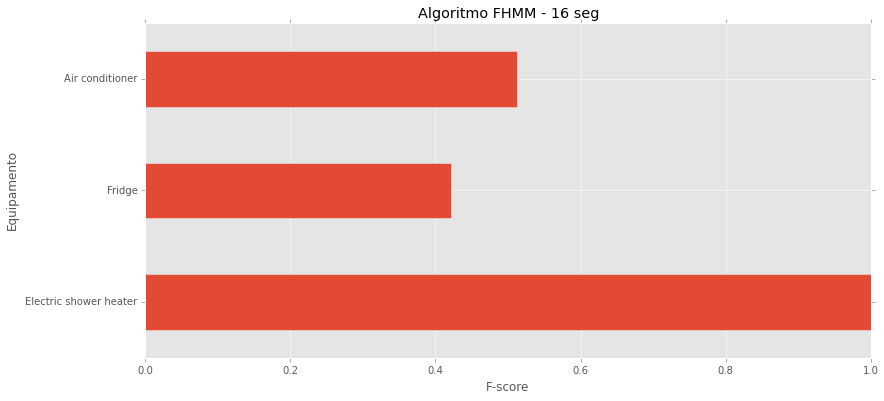

In [23]:
f1_fhmm.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('F-score');
plt.title("Algoritmo FHMM - 16 seg");

In [24]:
f1_fhmm

Electric shower heater    1.000000
Fridge                    0.421848
Air conditioner           0.512068
dtype: float64

In [25]:
#Métrica MNE. Representa o erro e quanto menor o seu valor, melhor é a precisão da desagregação.
from nilmtk.metrics import mean_normalized_error_power
mne_fhmm = mean_normalized_error_power(disag_fhmm_elec, test_elec)
mne_fhmm.index = disag_fhmm_elec.get_labels(mne_fhmm.index)

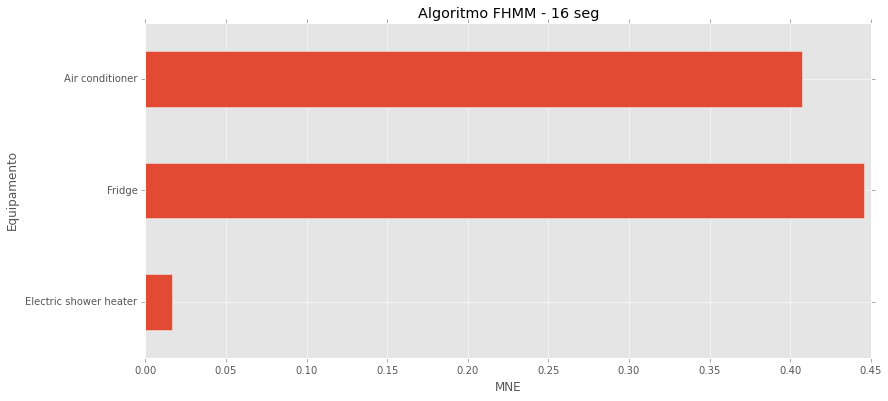

In [26]:
mne_fhmm.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('MNE');
plt.title("Algoritmo FHMM - 16 seg");

In [27]:
mne_fhmm

Electric shower heater    0.016413
Fridge                    0.445698
Air conditioner           0.407599
dtype: float64

In [28]:
#Métrica RMS. Representa o erro e quanto menor o seu valor, melhor é a precisão da desagregação.
from nilmtk.metrics import rms_error_power
rms_fhmm = rms_error_power(disag_fhmm_elec, test_elec)
rms_fhmm.index = disag_fhmm_elec.get_labels(rms_fhmm.index)

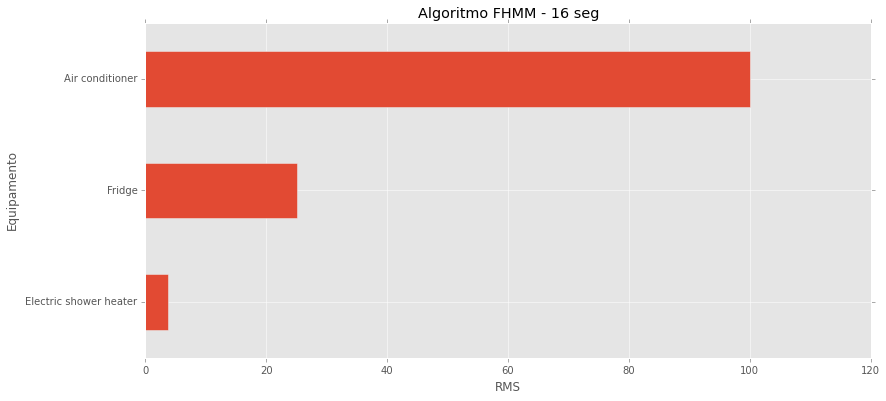

In [29]:
rms_fhmm.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('RMS');
plt.title("Algoritmo FHMM - 16 seg");

In [30]:
rms_fhmm

Electric shower heater      3.675898
Fridge                     25.055235
Air conditioner           100.007929
dtype: float64

In [31]:
#Métricas
#Arquivo com os resultados da métricas
path = '/home/harllan/Documentos/NILMTK_Disag/LAB_Tests/metrics_equip.txt'
result = ''

result = 'Fridge,16,FHMM,' + str(f1_fhmm['Fridge']) + ',' + str(mne_fhmm['Fridge']) + ',' + str(rms_fhmm['Fridge'])
result = result + '\n'
result = result + 'Shower,16,FHMM,' + str(f1_fhmm['Electric shower heater']) + ',' + str(mne_fhmm['Electric shower heater']) + ',' + str(rms_fhmm['Electric shower heater'])
result = result + '\n'
result = result + 'Air-conditioner,16,FHMM,' + str(f1_fhmm['Air conditioner']) + ',' + str(mne_fhmm['Air conditioner']) + ',' + str(rms_fhmm['Air conditioner'])

#Escrevendo em arquivo.txt
#'a' é de append, adiciona sem apagar o que já tem no arquivo
arquivo = open(path, 'a')
arquivo.write('\n')
arquivo.write(result)
arquivo.close()

In [32]:
#CO
from nilmtk.disaggregate import CombinatorialOptimisation
#Arquivo onde vai ficar os dados da desagregação
disag_filename = '/home/harllan/nilmtk/data/LAB/lab-disag-co-16seg.h5'
#Arquivo com os resultados do tempo
path = '/home/harllan/Documentos/NILMTK_Disag/LAB_Tests/time_algorithms.txt'
for i in range(30):
    print('Execution ' + str(i+1))
    result = ''
    #Treinando o algoritmo CO com uma frequência de 16 segundos
    start=time.time()
    co = CombinatorialOptimisation()
    co.train(top_3_train_elec, sample_period=16)
    end=time.time()
    #Tempo de treinamento do algoritmo
    result = str(end-start)
    
    #Desagregando os dados, também para uma frequência de 16 segundos
    start=time.time()
    #Coloca em HDF
    output = HDFDataStore(disag_filename, 'w')
    co.disaggregate(test_elec.mains(), output, sample_period=16)
    output.close()
    end=time.time()
    #Tempo de desagregação
    result = result + ',' + str(end-start) + ',CO,16'
    
    #Escrevendo em arquivo.txt
    #'a' é de append, adiciona sem apagar o que já tem no arquivo
    arquivo = open(path, 'a')
    arquivo.write('\n')
    arquivo.write(result)
    arquivo.close()

Execution 1
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])'
Done training!
vampire_power = 2.82842707634 watts
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])'
Execution 2
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appli

In [33]:
disag_co = DataSet(disag_filename)
disag_co_elec = disag_co.buildings[building].elec

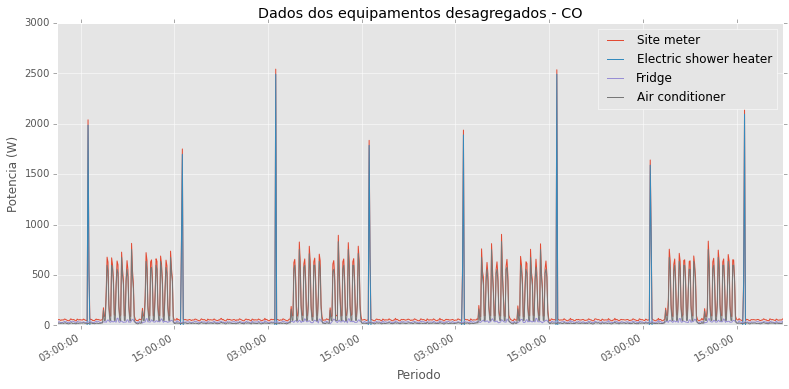

In [34]:
#Equipamentos desagregados
disag_co_elec.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados dos equipamentos desagregados - CO");

In [35]:
fridge_test = test_elec['fridge']
fridge_disag_co = disag_co_elec['fridge']

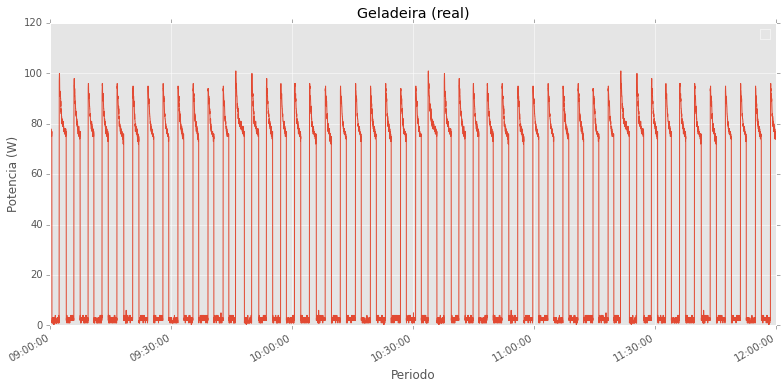

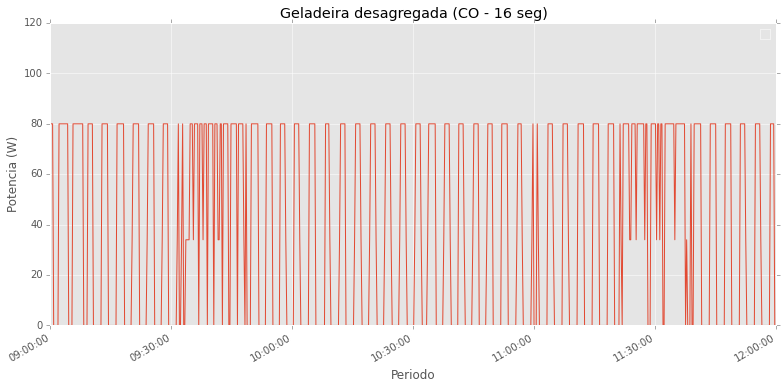

In [36]:
#Geladeira antes da desagregação (dados reais)
fridge_test_df = fridge_test.load().next()
fridge_test_df["2015-07-01 09:00:00":"2015-07-01 12:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira (real)");
plt.legend('');

#Geladeira após desagregação
fridge_disag_co_df = fridge_disag_co.load().next()
fridge_disag_co_df["2015-07-01 09:00:00":"2015-07-01 12:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.ylim(0,120)
plt.title("Geladeira desagregada (CO - 16 seg)");
plt.legend('');

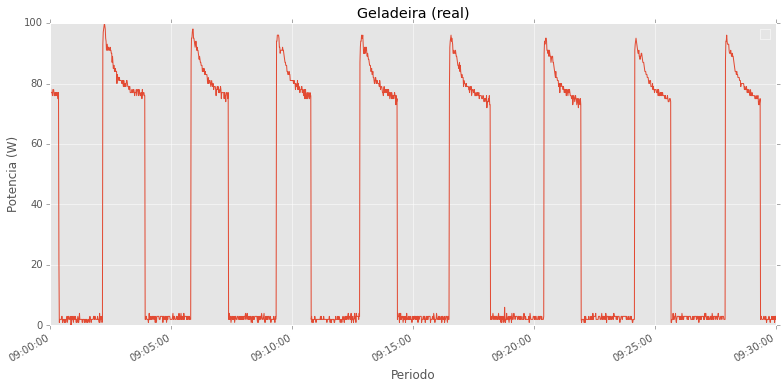

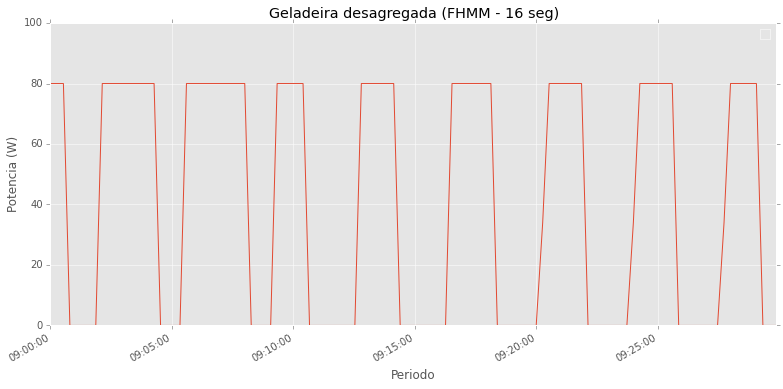

In [37]:
#Geladeira antes da desagregação (dados reais)
fridge_test_df = fridge_test.load().next()
fridge_test_df["2015-07-01 09:00:00":"2015-07-01 09:30:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira (real)");
plt.legend('');

#Geladeira após desagregação
fridge_disag_co_df = fridge_disag_co.load().next()
fridge_disag_co_df["2015-07-01 09:00:00":"2015-07-01 09:30:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.ylim(0,100)
plt.title("Geladeira desagregada (CO - 16 seg)");
plt.legend('');

In [38]:
shower_test = test_elec['electric shower heater']
shower_disag_co = disag_co_elec['electric shower heater']

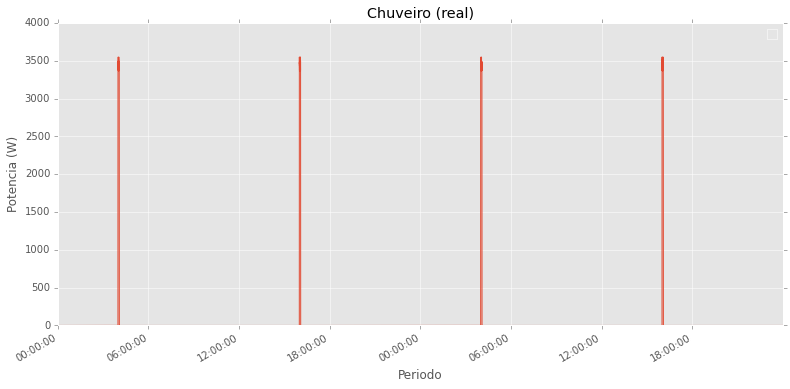

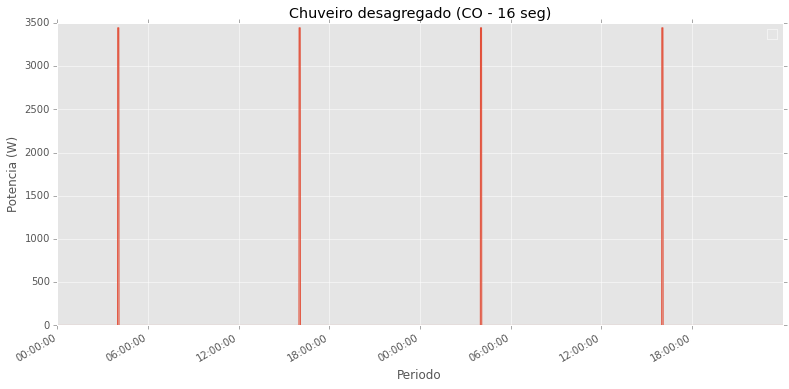

In [39]:
#Chuveiro antes da desagregação (dados reais)
shower_test_df = shower_test.load().next()
shower_test_df["2015-07-01":"2015-07-02"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Chuveiro (real)");
plt.legend('');

#Chuveiro após desagregação
shower_disag_co_df = shower_disag_co.load().next()
shower_disag_co_df["2015-07-01":"2015-07-02"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Chuveiro desagregado (CO - 16 seg)");
plt.legend('');

In [40]:
#Ar-condicionado
air_test = test_elec['air conditioner']
air_disag_co = disag_co_elec['air conditioner']

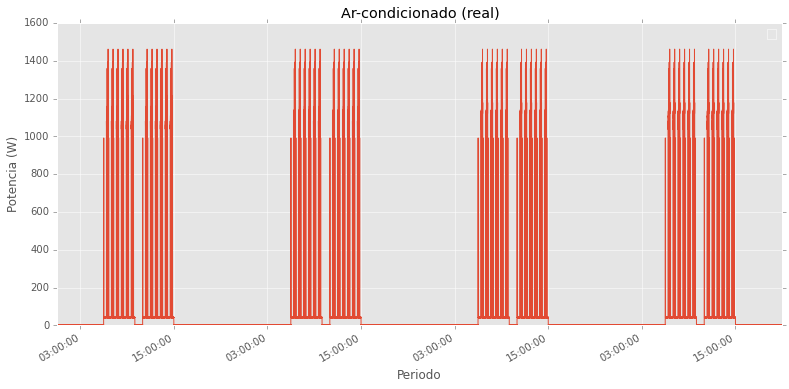

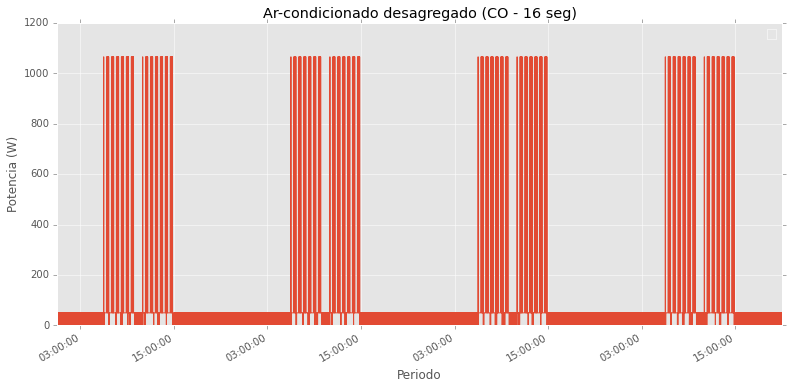

In [41]:
#Ar-condicionado antes da desagregação (dados reais)
air_test_df = air_test.load().next()
air_test_df.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado (real)");
plt.legend('');

#Ar-condicionado após desagregação
air_disag_co_df = air_disag_co.load().next()
air_disag_co_df.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado desagregado (CO - 16 seg)");
plt.legend('');

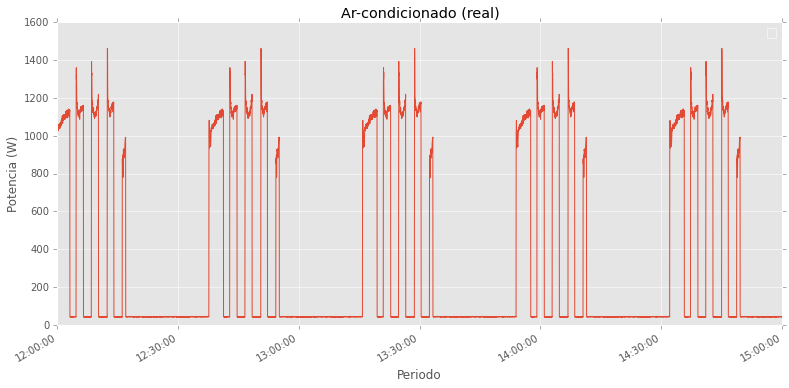

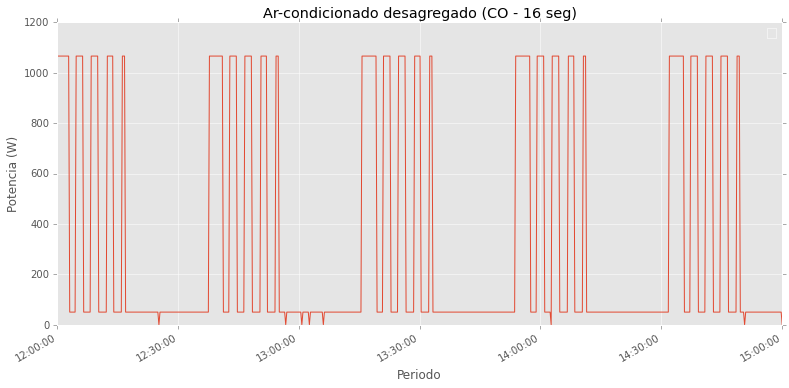

In [42]:
#Ar-condicionado antes da desagregação (dados reais)
air_test_df = air_test.load().next()
air_test_df["2015-07-01 12:00:00":"2015-07-01 15:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado (real)");
plt.legend('');

#Ar-condicionado após desagregação
air_disag_co_df = air_disag_co.load().next()
air_disag_co_df["2015-07-01 12:00:00":"2015-07-01 15:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado desagregado (CO - 16 seg)");
plt.legend('');

In [43]:
#Métrica f-score, para o algoritmo CO.
from nilmtk.metrics import f1_score
f1_co= f1_score(disag_co_elec, test_elec)
f1_co.index = disag_co_elec.get_labels(f1_co.index)

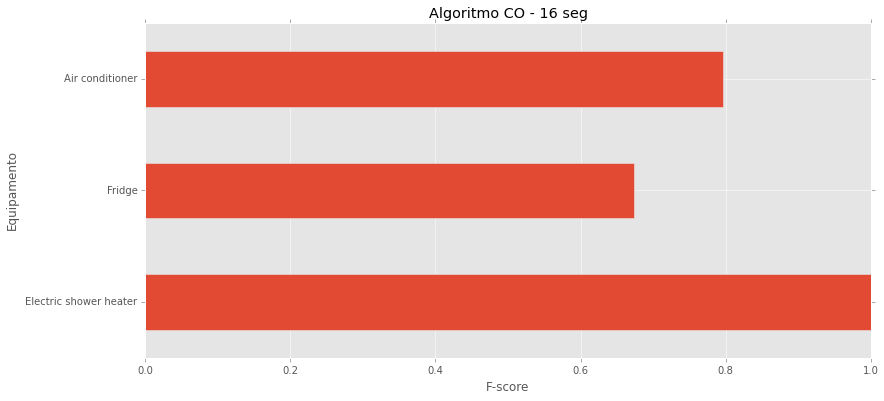

In [44]:
f1_co.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('F-score');
plt.title("Algoritmo CO - 16 seg");

In [45]:
f1_co

Electric shower heater    1.000000
Fridge                    0.673841
Air conditioner           0.795666
dtype: float64

In [46]:
#Métrica MNE.
from nilmtk.metrics import mean_normalized_error_power
mne_co = mean_normalized_error_power(disag_co_elec, test_elec)
mne_co.index = disag_co_elec.get_labels(mne_co.index)

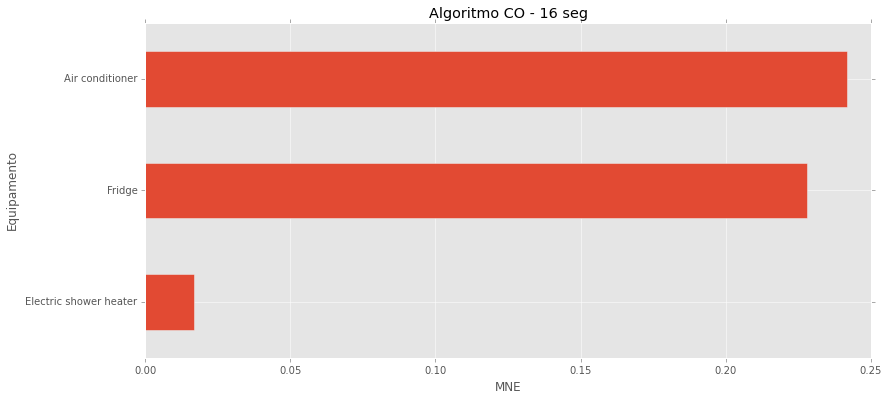

In [47]:
mne_co.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('MNE');
plt.title("Algoritmo CO - 16 seg");

In [48]:
mne_co

Electric shower heater    0.016847
Fridge                    0.228141
Air conditioner           0.241853
dtype: float64

In [49]:
#Métrica RMS.
from nilmtk.metrics import rms_error_power
rms_co = rms_error_power(disag_co_elec, test_elec)
rms_co.index = disag_co_elec.get_labels(rms_co.index)

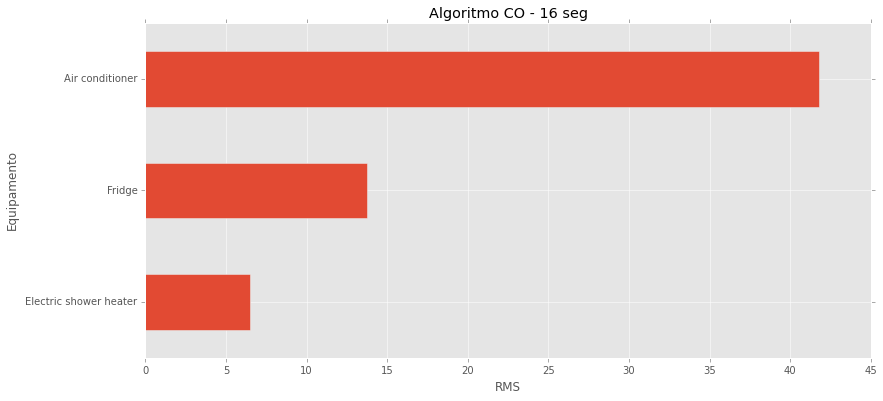

In [50]:
rms_co.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('RMS');
plt.title("Algoritmo CO - 16 seg");

In [51]:
rms_co

Electric shower heater     6.477541
Fridge                    13.754696
Air conditioner           41.768654
dtype: float64

In [52]:
#Métricas
#Arquivo com os resultados das métricas
path = '/home/harllan/Documentos/NILMTK_Disag/LAB_Tests/metrics_equip.txt'
result = ''

result = 'Fridge,16,CO,' + str(f1_co['Fridge']) + ',' + str(mne_co['Fridge']) + ',' + str(rms_co['Fridge'])
result = result + '\n'
result = result + 'Shower,16,CO,' + str(f1_co['Electric shower heater']) + ',' + str(mne_co['Electric shower heater']) + ',' + str(rms_co['Electric shower heater'])
result = result + '\n'
result = result + 'Air-conditioner,16,CO,' + str(f1_co['Air conditioner']) + ',' + str(mne_co['Air conditioner']) + ',' + str(rms_co['Air conditioner'])

#Escrevendo em arquivo.txt
#'a' é de append, adiciona sem apagar o que já tem no arquivo
arquivo = open(path, 'a')
arquivo.write('\n')
arquivo.write(result)
arquivo.close()